# 필수 라이브러리


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

from statsmodels.api import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
matplotlib.rc('font', family = 'NanumGothic')
matplotlib.rc('axes', unicode_minus = False)
import os
os.chdir('/home/piai/실습파일/BigData분석')

from sklearn.tree import export_graphviz
import graphviz
from subprocess import call
from IPython.display import Image

# 로지스틱 회귀분석

## 1. 데이터 구성하기

In [2]:
df = pd.read_csv("통신고객이탈.csv", encoding = 'euc-kr')
df.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHURN               930 non-null    object 
 1   CUSTOMER_ID         930 non-null    object 
 2   GENDER              930 non-null    object 
 3   AGE                 930 non-null    int64  
 4   CHARGE_TYPE         930 non-null    object 
 5   HANDSET             930 non-null    object 
 6   USAGE_BAND          930 non-null    object 
 7   SERVICE_DURATION    930 non-null    float64
 8   DROPPED_CALLS       930 non-null    int64  
 9   PEAK_CALLS_NO       930 non-null    int64  
 10  PEAK_CALLS_TIME     930 non-null    float64
 11  WEEKEND_CALLS_NO    930 non-null    int64  
 12  WEEKEND_CALLS_TIME  930 non-null    float64
 13  TOTAL_CALLS_NO      930 non-null    int64  
 14  TOTAL_CALLS_TIME    930 non-null    float64
dtypes: float64(4), int64(5), object(6)
memory usage: 109.1+ K

## 2. 데이터 전처리

### 2.1 결측치 확인 및 처리
- 결측치는 존재하지 않음.

In [4]:
df.isnull().sum()

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

### 2.2 상관관계 확인 & 다중공선성 제거
- (TOTAL_CALLS_NO, PEAK_CALLS_NO), (TOTAL_CALLS_TIME, PEAK_CALLS_NO), (WEEKEND_CALLS_NO, WEEKEND_CALLS_TIME)은 각각 0.92, 0.93, 0.71로 높은 양의 상관관계를 갖는 것을 확인할 수 있었다. 이에 따라 다중공선성이 존재할 것으로 예상해 VIF를 추가로 확인하였다.

/tmp/ipykernel_8127/221941791.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


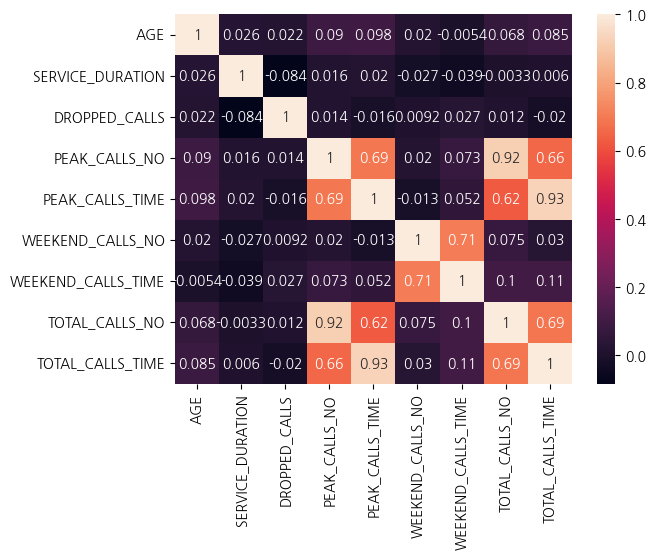

In [5]:
sns.heatmap(df.corr(), annot=True)
plt.show()

- X변수들간의 VIF를 통해 다중공선성을 확인하고자 하였다. VIF 10이상을 기준으로, TOTAL_CALLS_TIME, PEAK_CALLS_TIME, TOTAL_CALLS_NO이 각각 62.66 38.75, 35.54의 값을 가져 높은 다중공선성을 갖고 있는 것으로 확인되었으며, 이에 따라 VIF값이 가장 큰 TOTAL_CALLS_TIME 변수를 제거하였다.  
- TOTAL_CALLS_TIME 변수를 제거한 뒤에도, PEAK_CALLS_NO, TOTAL_CALLS_NO에 다중공선성이 존재하는 것으로 확인되었다. 마찬가지로 가장 높은 VIF값을 가지는 TOTAL_CALLS_NO 변수를 제거하였으며, 이 후의 X변수들 사이에는 다중공선성 문제가 발견되지 않았다.

In [6]:
df_x = df.select_dtypes(exclude=['object'])
df_vif = pd.DataFrame()
df_vif["variable"] = df_x.columns
df_vif["VIF"] = [variance_inflation_factor(df_x.values, i) \
                 for i in range(df_x.shape[1])]
# VIF 정렬
df_vif.sort_values("VIF", ascending = True).round(2)

,variable,VIF
2,DROPPED_CALLS,1.53
5,WEEKEND_CALLS_NO,4.09
1,SERVICE_DURATION,4.69
0,AGE,5.09
6,WEEKEND_CALLS_TIME,5.68
3,PEAK_CALLS_NO,24.22
7,TOTAL_CALLS_NO,35.54
4,PEAK_CALLS_TIME,38.75
8,TOTAL_CALLS_TIME,62.66


In [7]:
df_x = df_x.drop(columns = 'TOTAL_CALLS_TIME')
df_vif = pd.DataFrame()
df_vif["variable"] = df_x.columns
df_vif["VIF"] = [variance_inflation_factor(df_x.values, i) \
                 for i in range(df_x.shape[1])]
# VIF 정렬
df_vif.sort_values("VIF", ascending = True).round(2)

,variable,VIF
2,DROPPED_CALLS,1.53
5,WEEKEND_CALLS_NO,4.05
1,SERVICE_DURATION,4.50
0,AGE,4.91
4,PEAK_CALLS_TIME,5.27
6,WEEKEND_CALLS_TIME,5.40
3,PEAK_CALLS_NO,13.99
7,TOTAL_CALLS_NO,17.30


In [8]:
df_x = df_x.drop(columns = 'TOTAL_CALLS_NO')
df_vif = pd.DataFrame()
df_vif["variable"] = df_x.columns
df_vif["VIF"] = [variance_inflation_factor(df_x.values, i) \
                 for i in range(df_x.shape[1])]
# VIF 정렬
df_vif.sort_values("VIF", ascending = True).round(2)

,variable,VIF
2,DROPPED_CALLS,1.52
3,PEAK_CALLS_NO,3.84
5,WEEKEND_CALLS_NO,4.00
1,SERVICE_DURATION,4.34
0,AGE,4.79
4,PEAK_CALLS_TIME,5.26
6,WEEKEND_CALLS_TIME,5.39


- 다중공선성 제거 변수 : TOTAL_CALLS_TIME, TOTAL_CALLS_NO

In [9]:
df = df.drop(columns=['TOTAL_CALLS_TIME', 'TOTAL_CALLS_NO'])

### 2.3 불필요한 변수 제거

- CUSTOMER_ID는 Object형 변수로, 데이터 수에 따른 고유한 값(unique value)을 갖는다. 모델 예측의 성능을 저하시키는 변수로 생각되어 제거하였다.

In [10]:
print(df['CUSTOMER_ID'].nunique())
df = df.drop(columns = 'CUSTOMER_ID')

930


### 2.4 목표변수 불균형 확인 ( CHURN 변수) 및 인코딩


- 목표변수인 CHURN은 Active, Churned 두 개의 값만을 갖는 명목형 변수이다. 따라서 0,1(0:Active, 1:Churned)로 인코딩하였다.
- 추가적으로 값의 비율이 8:2인 불균형 데이터임을 확인하였다. 이에 따라 모델의 성능을 판단할 때, Accuracy뿐만 아니라, precision, recall, f1-score의 평가지표도 함께 고려해야함을 알 수 있다.

In [52]:
df['CHURN'].value_counts() / len(df)

0    0.806452
1    0.193548
Name: CHURN, dtype: float64

In [12]:
df.loc[df['CHURN']=='Churned', 'CHURN'] = 1 
df.loc[df['CHURN']=='Active', 'CHURN'] = 0
df['CHURN'] = df['CHURN'].astype(int)
df['CHURN'].head()

0    0
1    0
2    0
3    0
4    0
Name: CHURN, dtype: int64

### 2.5 데이터 분할

- 데이터는 7:3 비율로 Training set, Test set으로 분리하였으며, 두 개의 unique 값을 갖는 목표변수 CHURN이 Training set, Test set에 같은 비율로 포함되게 하였다.

In [13]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 240307, stratify = df['CHURN'])
print('training data size : {}'.format(df_train.shape))
print('test data size : {}'.format(df_test.shape))

training data size : (651, 12)
test data size : (279, 12)


## 3. 모델 및 회귀계수 검토

- object형 변수확인

In [15]:
df_train.select_dtypes(include=['object']).columns.tolist()

['GENDER', 'CHARGE_TYPE', 'HANDSET', 'USAGE_BAND']

### 3.1 model 1 : 회귀계수가 유의하지 않은 설명변수를 제거하지 않음

In [16]:
log_model1 = Logit.from_formula("""CHURN  ~  C(GENDER) + AGE + C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND) + 
                               SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME + WEEKEND_CALLS_NO +
                               WEEKEND_CALLS_TIME""",df_train)
log_result1 = log_model1.fit()
print(log_result1.summary())

         Current function value: 0.245549
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      623
Method:                           MLE   Df Model:                           27
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.5002
Time:                        20:59:41   Log-Likelihood:                -159.85
converged:                      False   LL-Null:                       -319.85
Covariance Type:            nonrobust   LLR p-value:                 7.339e-52
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -28.6649   5.56e+04     -0.001      1.000   -1.09e+05    1.09e+05
C(GENDER)[T.M]   

/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 3.2 model 2: 회귀계수가 유의하지 않은 설명변수를 모두 제거함

##### 범주형 변수 HANDSET 제거

In [17]:
log_model2 = Logit.from_formula("""CHURN  ~  C(GENDER) + AGE + C(CHARGE_TYPE) + C(USAGE_BAND) + 
                               SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME + WEEKEND_CALLS_NO +
                               WEEKEND_CALLS_TIME""",df_train)
log_result2 = log_model2.fit()
print(log_result2.summary())

Optimization terminated successfully.
         Current function value: 0.434377
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      633
Method:                           MLE   Df Model:                           17
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.1159
Time:                        20:59:42   Log-Likelihood:                -282.78
converged:                       True   LL-Null:                       -319.85
Covariance Type:            nonrobust   LLR p-value:                 4.114e-09
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.3620      1.108     -1.229      0.219      

##### WEEKEND_CALLS_NO  제거 

In [18]:
log_model2 = Logit.from_formula("""CHURN  ~  C(GENDER) + AGE + C(CHARGE_TYPE) + C(USAGE_BAND) + 
                               SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME +
                               WEEKEND_CALLS_TIME""",df_train)
log_result2 = log_model2.fit()
print(log_result2.summary())

Optimization terminated successfully.
         Current function value: 0.434489
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      634
Method:                           MLE   Df Model:                           16
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.1157
Time:                        20:59:42   Log-Likelihood:                -282.85
converged:                       True   LL-Null:                       -319.85
Covariance Type:            nonrobust   LLR p-value:                 1.965e-09
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.3697      1.108     -1.236      0.216      

##### WEEKEND_CALLS_TIME 제거

In [19]:
log_model2 = Logit.from_formula("""CHURN  ~  C(GENDER) + AGE + C(CHARGE_TYPE) + C(USAGE_BAND) + 
                               SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME""",df_train)
log_result2 = log_model2.fit()
print(log_result2.summary())

Optimization terminated successfully.
         Current function value: 0.434541
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      635
Method:                           MLE   Df Model:                           15
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.1156
Time:                        20:59:42   Log-Likelihood:                -282.89
converged:                       True   LL-Null:                       -319.85
Covariance Type:            nonrobust   LLR p-value:                 8.811e-10
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.2925      1.067     -1.211      0.226      

##### PEAK_CALLS_NO 제거

In [20]:
log_model2 = Logit.from_formula("""CHURN  ~  C(GENDER) + AGE + C(CHARGE_TYPE) + C(USAGE_BAND) + 
                               SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_TIME""",df_train)
log_result2 = log_model2.fit()
print(log_result2.summary())

Optimization terminated successfully.
         Current function value: 0.434743
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      636
Method:                           MLE   Df Model:                           14
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.1152
Time:                        20:59:42   Log-Likelihood:                -283.02
converged:                       True   LL-Null:                       -319.85
Covariance Type:            nonrobust   LLR p-value:                 4.142e-10
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.2791      1.066     -1.200      0.230      

##### 범주형 변수 GENDER 제거

In [21]:
log_model2 = Logit.from_formula("""CHURN  ~  AGE + C(CHARGE_TYPE) + C(USAGE_BAND) + SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_TIME""",
                                df_train)
log_result2 = log_model2.fit()
print(log_result2.summary())

Optimization terminated successfully.
         Current function value: 0.434968
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      637
Method:                           MLE   Df Model:                           13
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.1147
Time:                        20:59:42   Log-Likelihood:                -283.16
converged:                       True   LL-Null:                       -319.85
Covariance Type:            nonrobust   LLR p-value:                 1.904e-10
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.2724      1.066     -1.193      0.233      

##### PEAK_CALLS_TIME 

In [22]:
log_model2 = Logit.from_formula("""CHURN  ~  AGE + C(CHARGE_TYPE) + C(USAGE_BAND) + SERVICE_DURATION + DROPPED_CALLS""",df_train)
log_result2 = log_model2.fit()
print(log_result2.summary())

Optimization terminated successfully.
         Current function value: 0.436668
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      638
Method:                           MLE   Df Model:                           12
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                  0.1112
Time:                        20:59:42   Log-Likelihood:                -284.27
converged:                       True   LL-Null:                       -319.85
Covariance Type:            nonrobust   LLR p-value:                 1.937e-10
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0218      0.607      0.036      0.971      

## 4. 예측 및 성능 평가

### 4.1 예측결과 & 평가
- 모델1과 모델2의 예측 결과를 비교해 보면, Test set의 기준으로 0(Achieve)에 대해서는 두 모델 모두 잘 예측하는 반면 모델 1에서 1(Churned)에 대한 precision, recall, f1_score의 값이 모두 높게 나타났음을 알 수 있다.

##### 모델 1의 예측 결과 및 평가

In [23]:
print("*"*70)
print("model 1의 예측 결과 및 평가")
print("*"*70)

print("model1 Confusion Matrix")
print()
y_pred_train = log_result1.predict(df_train)
y_pred_train_class = (y_pred_train > 0.5).astype(int)
print("model1 Train Confusion Matrix: \n{}".format(confusion_matrix(df_train['CHURN'],y_pred_train_class)), '\n')

y_pred_test = log_result1.predict(df_test)
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print("model1 Test Confusion Matrix: \n{}".format(confusion_matrix(df_test['CHURN'],y_pred_test_class)), '\n')
print('-'*70)

print("model1 Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["CHURN"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["CHURN"],y_pred_train_class)),"\n")
print(classification_report(df_train["CHURN"], y_pred_train_class, digits=3))

print('-'*70)

print("model1 Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["CHURN"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["CHURN"],y_pred_test_class)),"\n")
print(classification_report(df_test["CHURN"], y_pred_test_class, digits=3))

**********************************************************************
model 1의 예측 결과 및 평가
**********************************************************************
model1 Confusion Matrix

model1 Train Confusion Matrix: 
[[505  20]
 [ 42  84]] 

model1 Test Confusion Matrix: 
[[213  12]
 [ 17  37]] 

----------------------------------------------------------------------
model1 Train 예측/분류 결과
Accuracy: 0.905

Confusion Matrix: 
[[505  20]
 [ 42  84]] 

              precision    recall  f1-score   support

           0      0.923     0.962     0.942       525
           1      0.808     0.667     0.730       126

    accuracy                          0.905       651
   macro avg      0.865     0.814     0.836       651
weighted avg      0.901     0.905     0.901       651

----------------------------------------------------------------------
model1 Test 예측/분류 결과
Accuracy: 0.896

Confusion Matrix: 
[[213  12]
 [ 17  37]] 

              precision    recall  f1-score   support

           

##### 모델 2의 예측 결과 및 평가

In [24]:
print("*"*70)
print("model 2의 예측 결과 및 평가")
print("*"*70)

print("model2 Confusion Matrix")
print()
y_pred_train = log_result2.predict(df_train)
y_pred_train_class = (y_pred_train > 0.5).astype(int)
print("model2 Train Confusion Matrix: \n{}".format(confusion_matrix(df_train['CHURN'],y_pred_train_class)), '\n')

y_pred_test = log_result2.predict(df_test)
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print("model2 Test Confusion Matrix: \n{}".format(confusion_matrix(df_test['CHURN'],y_pred_test_class)), '\n')
print('-'*70)

print("model2 Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["CHURN"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["CHURN"],y_pred_train_class)),"\n")
print(classification_report(df_train["CHURN"], y_pred_train_class, digits=3))

print('-'*70)

print("model2 Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["CHURN"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["CHURN"],y_pred_test_class)),"\n")
print(classification_report(df_test["CHURN"], y_pred_test_class, digits=3))

**********************************************************************
model 2의 예측 결과 및 평가
**********************************************************************
model2 Confusion Matrix

model2 Train Confusion Matrix: 
[[519   6]
 [106  20]] 

model2 Test Confusion Matrix: 
[[218   7]
 [ 41  13]] 

----------------------------------------------------------------------
model2 Train 예측/분류 결과
Accuracy: 0.828

Confusion Matrix: 
[[519   6]
 [106  20]] 

              precision    recall  f1-score   support

           0      0.830     0.989     0.903       525
           1      0.769     0.159     0.263       126

    accuracy                          0.828       651
   macro avg      0.800     0.574     0.583       651
weighted avg      0.819     0.828     0.779       651

----------------------------------------------------------------------
model2 Test 예측/분류 결과
Accuracy: 0.828

Confusion Matrix: 
[[218   7]
 [ 41  13]] 

              precision    recall  f1-score   support

           

## 5. 결론 도출

##### 성능이 더 좋은 모델1의 변수의 중요도 확인

<Axes: >

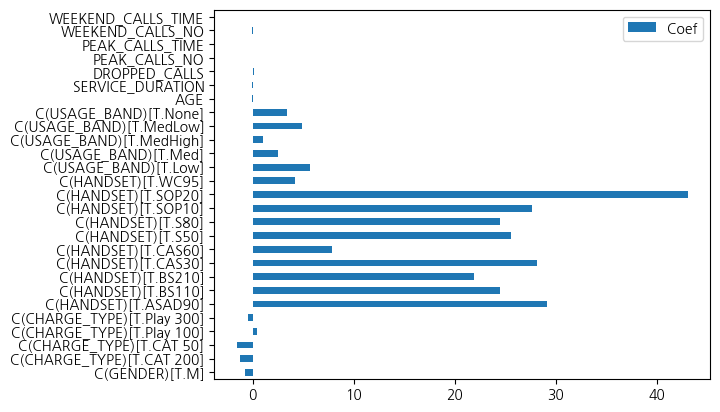

In [25]:
df_logistic_coef = pd.DataFrame({"Coef": log_result1.params.values[1:]}, index = log_model1.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")

# 의사결정나무

## 1. 데이터 구성하기

In [26]:
df.head()

,CHURN,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME
0,0,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6
1,0,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0
2,0,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0
3,0,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5
4,0,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0


### 1.1 범주형 설명변수 더미변환

- 범주형 설명변수인 GENDER, CHARGE_TYPE, HANDSET, USAGE_BAND에 대한 One-Hot encoding을 통해 더미변수로 변환해 주었다.

In [27]:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,GENDER_F,GENDER_M,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,0,31,33.33,6,218,379.8,9,21.6,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,27,30.87,10,373,656.4,11,28.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,27,49.40,11,260,582.0,0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,61,48.60,1,294,661.8,14,101.5,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,52,56.03,0,221,555.6,7,25.0,1,0,...,0,0,0,0,0,0,1,0,0,0


### 1.2 데이터 분리 및 분할

- 데이터는 7:3 비율로 Training set, Test set으로 분리하였으며, 두 개의 unique 값을 갖는 목표변수 CHURN이 Training set, Test set에 같은 비율로 포함되게 하였다.

In [28]:
df_x = df_dummy.drop(columns = 'CHURN')
df_y = df_dummy['CHURN']
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3, random_state = 240307, stratify = df_y) 
print("분할 전 설명변수 데이터 :", df_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (930, 31)
분할 후 설명변수 데이터 :Train (651, 31)   Test (279, 31)


## 2. 모델 생성

In [29]:
tree_uncust = DecisionTreeClassifier(random_state=240307)
tree_uncust.fit(df_train_x, df_train_y)
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.828


In [30]:
print(tree_uncust.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 240307, 'splitter': 'best'}


- default 모델(파라미터를 조정하지 않은 모델)은 Training 데이터 셋에 대하여, 모두 100%에 가까운 예측 성공률을 나타냈으며, Test 데이터 셋에 대하여, 0에 대해서는 높은 예측률을 보였으나, 비교적 낮은 precision, recall, f1-score값을 통해 예측력이 미흡함을 알 수 있었다.

In [31]:
y_pred_dt_train = tree_uncust.predict(df_train_x)
y_pred_dt_test = tree_uncust.predict(df_test_x)

print("model2 Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["CHURN"], y_pred_dt_train)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["CHURN"],y_pred_dt_train)),"\n")
print(classification_report(df_train["CHURN"], y_pred_dt_train, digits=3))

print('-'*70)

print("model2 Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["CHURN"], y_pred_dt_test)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["CHURN"],y_pred_dt_test)),"\n")
print(classification_report(df_test["CHURN"], y_pred_dt_test, digits=3))

model2 Train 예측/분류 결과
Accuracy: 1.000

Confusion Matrix: 
[[525   0]
 [  0 126]] 

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       525
           1      1.000     1.000     1.000       126

    accuracy                          1.000       651
   macro avg      1.000     1.000     1.000       651
weighted avg      1.000     1.000     1.000       651

----------------------------------------------------------------------
model2 Test 예측/분류 결과
Accuracy: 0.828

Confusion Matrix: 
[[196  29]
 [ 19  35]] 

              precision    recall  f1-score   support

           0      0.912     0.871     0.891       225
           1      0.547     0.648     0.593        54

    accuracy                          0.828       279
   macro avg      0.729     0.760     0.742       279
weighted avg      0.841     0.828     0.833       279



## 3. 모델 parameter 조정

### 3.1 max_depth : 최대 깊이 변경에 따른 모델 성능
- Depth가 5일 때, test Accuracy가 0.871로 가장 높고, train Accuracy 또한 충분히 잘 설명하고 있다. 이에 따라 max_depth를 5로 정하였다.

In [32]:
train_accuracy = []; test_accuracy = []
para_depth = [depth for depth in range(3, 12)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state=240307)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [33]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,3,0.897,0.871
1,4,0.903,0.867
2,5,0.912,0.871
3,6,0.928,0.871
4,7,0.943,0.846
5,8,0.952,0.849
6,9,0.971,0.817
7,10,0.982,0.821
8,11,0.985,0.839


### 3.2 min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능 - 전체 자료 수 고려
- Depth가 5이면서, min_samples_split가 40일 때, test Accuracy가 0.903으로 가장 높고, train Accuracy 또한 충분히 잘 설명하고 있다. 이에 따라min_samples_split를 40으로 정하였다.

In [34]:
train_accuracy = []; test_accuracy = []
para_split = [n_split * 10 for n_split in range(2, 16)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth=5, random_state=240307)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [35]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.899,0.892
1,30,0.897,0.903
2,40,0.897,0.903
3,50,0.892,0.896
4,60,0.892,0.896
5,70,0.892,0.896
6,80,0.892,0.896
7,90,0.892,0.896
8,100,0.892,0.896
9,110,0.892,0.896


### 3.3 min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능
- Depth가 5이면서, min_samples_split가 40, min_samples_leaf가 18일 때, test Accuracy가 0.914로 가장 높고, train Accuracy 또한 충분히 잘 설명하고 있다. 이에 따라 min_samples_leaf를 18으로 정하였다.

In [36]:
train_accuracy = []; test_accuracy = []
para_leaf = [n_leaf * 2 for n_leaf in range(5,16)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, min_samples_split=40, max_depth=5, random_state=240307)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [37]:
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.897,0.903
1,12,0.897,0.903
2,14,0.897,0.892
3,16,0.896,0.892
4,18,0.896,0.914
5,20,0.892,0.896
6,22,0.874,0.871
7,24,0.853,0.860
8,26,0.853,0.860
9,28,0.853,0.860


## 4. 최종 모델 선정 및 시각화

### 4.1 최종 모델 선정

- 최종적으로 파라미터가 조정된(max_depth=5, min_samples_split=40, min_samples_leaf=18) Dicision Tree는 다음과 같다.

In [38]:
tree_final = DecisionTreeClassifier(max_depth=5, min_samples_split=40, min_samples_leaf=18, random_state=240307)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=18, min_samples_split=40,
                       random_state=240307)

### 4.2 트리 모델 시각화 및 해석

- 파라미터에 따라 트리의 높이는 5로 생성되었고, 조건에 따라 최종적으로 7개의 노드로 분기하였음을 확인할 수 있다.

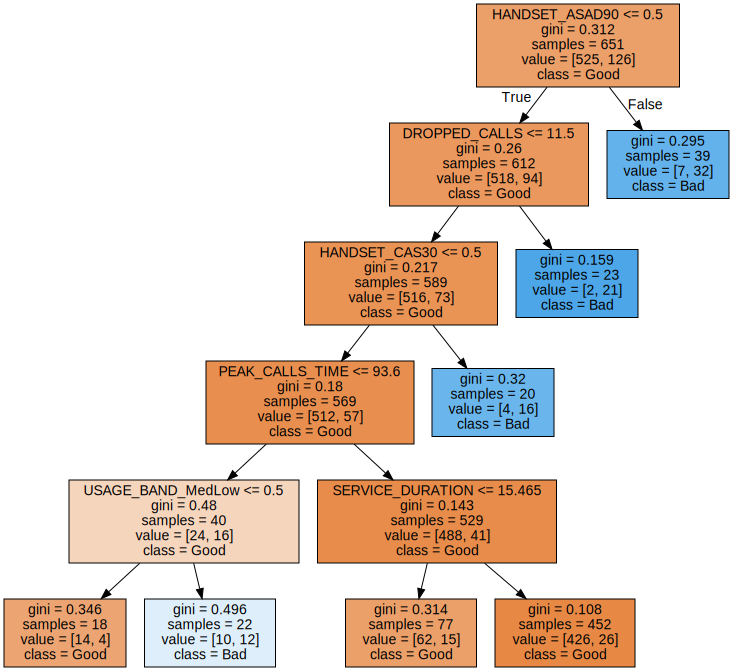

In [39]:
export_graphviz(tree_final, out_file="tree_final.dot", class_names = ["Good", "Bad"],
                feature_names = df_train_x.columns, impurity = True, filled = True)

with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 4.3 최종 모델을 이용한 분류 예측

- Test 데이터 셋을 기준으로 기존의 모델보다 1에 대한 예측력이 높아졌음을 알 수 있다. 1에 대한 예측력 상승의 근거로 precision, recall, f1-score의 지표가 기존보다 전부 0.1~0.2정도 향상된 것을 들 수 있다.
- 1 뿐만 아니라 0에 대해서도 모든 평가지표들이 높아짐을 통해 전체적인 값들에 대해 모델의 예측 성능이 높아졌다고 말할 수 있을 것이다.

In [40]:
y_pred = tree_final.predict(df_train_x)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_train_x, df_train_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_train_y, y_pred)))
print(classification_report(df_train_y, y_pred, digits=3))
print("-"*70)
y_pred = tree_final.predict(df_test_x)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Test Accuracy: 0.896

Test Confusion matrix: 
[[502  23]
 [ 45  81]]
              precision    recall  f1-score   support

           0      0.918     0.956     0.937       525
           1      0.779     0.643     0.704       126

    accuracy                          0.896       651
   macro avg      0.848     0.800     0.820       651
weighted avg      0.891     0.896     0.892       651

----------------------------------------------------------------------
Test Accuracy: 0.914

Test Confusion matrix: 
[[213  12]
 [ 12  42]]
              precision    recall  f1-score   support

           0      0.947     0.947     0.947       225
           1      0.778     0.778     0.778        54

    accuracy                          0.914       279
   macro avg      0.862     0.862     0.862       279
weighted avg      0.914     0.914     0.914       279



## 5. 결론 도출

### 5.1 설명변수의 중요도 결과

- 의사결정나무의 생성시 HANDSET_ASAD90, DROPPED_CALLS, HANDSET_CAS30 순으로 중요한 것을 확인할 수 있다.   
변수 중요도가 0인 USAGE_BAND_MedHigh, USAGE_BAND_Med, USAGE_BAND_Low, HANDSET_BS210의 변수는 의사결정나무의 분기와 전혀 관련없는 변수일 수 있으나, 데이터 셋이 다르게 분할됨에 따라 변수 중요도는 다르게 나타날 수 있다.

In [41]:
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3).head(10)

,Feature,Importance
15,HANDSET_ASAD90,0.357
2,DROPPED_CALLS,0.302
18,HANDSET_CAS30,0.207
4,PEAK_CALLS_TIME,0.085
1,SERVICE_DURATION,0.027
29,USAGE_BAND_MedLow,0.023
28,USAGE_BAND_MedHigh,0.000
27,USAGE_BAND_Med,0.000
26,USAGE_BAND_Low,0.000
17,HANDSET_BS210,0.000


### 5.2 변수 중요도 시각화

Text(0, 0.5, '설명변수')

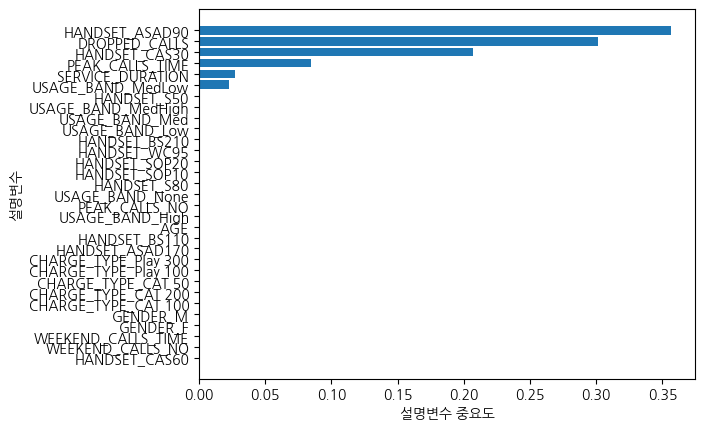

In [42]:
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

# RandomForest

## 1. 데이터 구성하기

- 로지스틱 회귀모형 데이터 셋, 의사결정나무 데이터 셋과 동일하므로, 전처리가 일부 진행된 데이터 셋을 가져옴 

In [43]:
df.head()

,CHURN,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME
0,0,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6
1,0,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0
2,0,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0
3,0,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5
4,0,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0


### 1.1 범주형 설명변수 더미변환

- 범주형 설명변수인 GENDER, CHARGE_TYPE, HANDSET, USAGE_BAND에 대한 One-Hot encoding을 통해 더미변수로 변환해 주었다.

In [44]:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,GENDER_F,GENDER_M,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,0,31,33.33,6,218,379.8,9,21.6,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,27,30.87,10,373,656.4,11,28.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,27,49.40,11,260,582.0,0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,61,48.60,1,294,661.8,14,101.5,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,52,56.03,0,221,555.6,7,25.0,1,0,...,0,0,0,0,0,0,1,0,0,0


### 1.2 데이터 분리 및 분할

- 데이터는 7:3 비율로 Training set, Test set으로 분리하였으며, 두 개의 unique 값을 갖는 목표변수 CHURN이 Training set, Test set에 같은 비율로 포함되게 하였다.

In [45]:
df_x = df_dummy.drop(columns = 'CHURN')
df_y = df_dummy['CHURN']
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3, random_state = 240307, stratify = df_y) 
print("분할 전 설명변수 데이터 :", df_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (930, 31)
분할 후 설명변수 데이터 :Train (651, 31)   Test (279, 31)


## 2. 모델 생성

In [46]:
rf_uncust = RandomForestClassifier(random_state=240307)
rf_uncust.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(rf_uncust.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_uncust.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.900


In [49]:
print(rf_uncust.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 240307, 'verbose': 0, 'warm_start': False}


- default 모델(파라미터를 조정하지 않은 모델)은 Training 데이터 셋에 대하여, 모두 100%에 가까운 예측 성공률을 나타냈으며, Test 데이터 셋에 대하여, 0에 대해서는 높은 예측률을 보였으나, 비교적 낮은 precision, recall, f1-score값을 통해 예측력이 미흡함을 알 수 있었다.

In [50]:
y_pred_rf_train = rf_uncust.predict(df_train_x)
y_pred_rf_test = rf_uncust.predict(df_test_x)

print("model2 Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["CHURN"], y_pred_rf_train)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["CHURN"],y_pred_rf_train)),"\n")
print(classification_report(df_train["CHURN"], y_pred_rf_train, digits=3))

print('-'*70)

print("model2 Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["CHURN"], y_pred_rf_test)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["CHURN"],y_pred_rf_test)),"\n")
print(classification_report(df_test["CHURN"], y_pred_rf_test, digits=3))

model2 Train 예측/분류 결과
Accuracy: 1.000

Confusion Matrix: 
[[525   0]
 [  0 126]] 

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       525
           1      1.000     1.000     1.000       126

    accuracy                          1.000       651
   macro avg      1.000     1.000     1.000       651
weighted avg      1.000     1.000     1.000       651

----------------------------------------------------------------------
model2 Test 예측/분류 결과
Accuracy: 0.900

Confusion Matrix: 
[[216   9]
 [ 19  35]] 

              precision    recall  f1-score   support

           0      0.919     0.960     0.939       225
           1      0.795     0.648     0.714        54

    accuracy                          0.900       279
   macro avg      0.857     0.804     0.827       279
weighted avg      0.895     0.900     0.896       279



## 3 모델 파라미터 조정

### 3.1 n_estimator : 최대 깊이 변경에 따른 모델 성능
- n_estimators가 80일 때, test Accuracy가 0.910으로 가장 높고, train Accuracy는 완벽히 잘 설명하고 있다. 이에 따라 max_depth를 10로 정하였다.

In [51]:
train_accuracy = []; test_accuracy = []
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators, random_state = 240307)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [53]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.986,0.892
1,20,0.995,0.892
2,30,1.000,0.889
3,40,1.000,0.885
4,50,1.000,0.900
5,60,1.000,0.896
6,70,1.000,0.907
7,80,1.000,0.910
8,90,1.000,0.910
9,100,1.000,0.907


### 3.2 max_depth : 최대 깊이 변경에 따른 모델 성능
- n_estimators가 80이고, depth가 10일 때, test Accuracy가 0.903로 가장 높고, train Accuracy 또한 충분히 잘 설명하고 있다. 이에 따라 max_depth를 10로 정하였다.

In [61]:
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(3, 11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth, n_estimators=80, random_state=240307)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [62]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,3,0.836,0.821
1,4,0.873,0.828
2,5,0.906,0.842
3,6,0.926,0.871
4,7,0.932,0.871
5,8,0.937,0.882
6,9,0.939,0.892
7,10,0.945,0.903


### 3.3 MinSamplesLeaf : 조정에 따른 정확도 변화
- n_estimators가 80이고, depth가 10, MinSamplesLeaf가 5일 때, test Accuracy가 0.903로 가장 높고, train Accuracy 또한 충분히 잘 설명하고 있다. 이에 따라 MinSamplesLeaf를 5로 정하였다.

In [65]:
train_accuracy = []; test_accuracy = []
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf = v_min_samples_leaf,
                                max_depth=6, n_estimators=100, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [67]:
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.888,0.864
1,10,0.874,0.832
2,15,0.820,0.806
3,20,0.806,0.806
4,25,0.806,0.806
5,30,0.806,0.806
6,35,0.806,0.806
7,40,0.806,0.806
8,45,0.806,0.806
9,50,0.806,0.806


## 4. 결론

- 파라미터를 조정한 모델보다 파라미터를 조절하지 않는 default모델이 0, 1에 대해 더 예측 성능이 좋았음을 확인할 수 있다.
- 이는 파라미터 조정 범위가 잘못되었거나, 파라미터들의 조합이 잘못되었을 수 있을 것이다.

In [68]:
rf_final = RandomForestClassifier(min_samples_leaf=5, max_depth=10, n_estimators=80,
                                  random_state=240307)
rf_final.fit(df_train_x, df_train_y)
y_pred = rf_final.predict(df_test_x)

print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 0.914
Accuracy on test set: 0.900

Confusion matrix: 
[[217   8]
 [ 20  34]]
              precision    recall  f1-score   support

           0      0.916     0.964     0.939       225
           1      0.810     0.630     0.708        54

    accuracy                          0.900       279
   macro avg      0.863     0.797     0.824       279
weighted avg      0.895     0.900     0.895       279



- 의사결정나무의 생성시 HANDSET_ASAD90, DROPPED_CALLS순으로 중요한 것을 확인할 수 있다.   
변수 중요도가 낮거나 0인 경우의 변수는 의사결정나무의 분기와 전혀 관련없는 변수일 수 있으나, 데이터 셋이 다르게 분할됨에 따라 변수 중요도는 다르게 나타날 수 있다.

In [73]:
v_feature_names = df_train_x.columns
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_uncust .feature_importances_
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3).head(10)

,Feature,Importance
15,HANDSET_ASAD90,0.127
2,DROPPED_CALLS,0.114
4,PEAK_CALLS_TIME,0.092
3,PEAK_CALLS_NO,0.082
0,AGE,0.082
1,SERVICE_DURATION,0.081
6,WEEKEND_CALLS_TIME,0.068
18,HANDSET_CAS30,0.060
5,WEEKEND_CALLS_NO,0.052
20,HANDSET_S50,0.022


Text(0, 0.5, '설명변수')

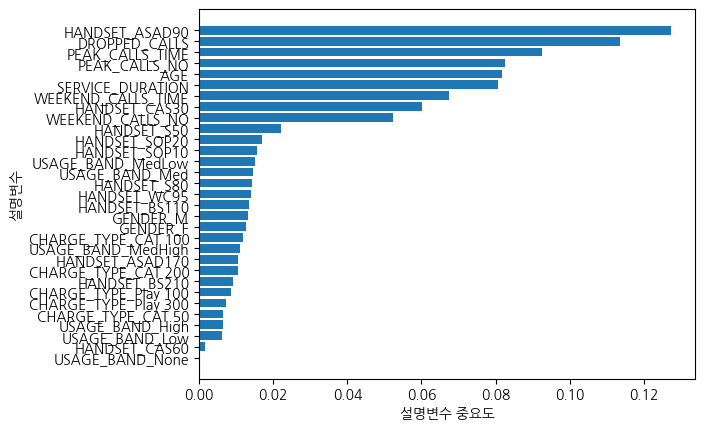

In [74]:
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")